Resumo dos Hiperparâmetros Utilizados Experimento 4

### **Resumo do Experimento #4: U-Net com Augmentation Leve (torchvision)**

* **Objetivo:** Melhorar a capacidade de generalização do modelo base (Experimento #2) através da adição de técnicas de Data Augmentation de baixo custo computacional, garantindo um treinamento eficiente.

* **Arquitetura do Modelo:**
    * U-Net

* **Configuração do Treinamento:**
    * **Função de Perda:** Dice + BCE Loss (`DiceBCELoss`)
    * **Otimizador:** Adam
    * **Taxa de Aprendizado Inicial:** `1e-4`
    * **Batch Size:** `4`
    * **Número Máximo de Épocas:** `100`

* **Agendador de Taxa de Aprendizado (Scheduler):**
    * **Estratégia:** `ReduceLROnPlateau`
    * **Métrica Monitorada:** `Validation IoU`
    * **Paciência:** `5` épocas
    * **Fator de Redução:** `0.2`

* **Data Augmentation (aplicada apenas no treino via `torchvision.transforms.functional`):**
    * Flip Horizontal Aleatório (probabilidade de 50%)
    * Flip Vertical Aleatório (probabilidade de 50%)

In [1]:
# CELULA 1
# Importar as bibliotecas necessárias
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import concurrent.futures
import csv
import pandas as pd
import seaborn as sns
from torchvision.transforms import functional as F

In [2]:
# CELULA 2
# Defina os caminhos
SOURCE_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data"
TARGET_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" # Nova pasta
TARGET_SIZE = (256, 256)

# print(f"Criando nova estrutura de pastas em: {TARGET_DATA_DIR}")
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/masks"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/masks"), exist_ok=True)

# def process_single_image(args):
#     filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder = args
#     try:
#         with Image.open(os.path.join(source_img_folder, filename)) as img:
#             img_resized = img.resize(TARGET_SIZE, Image.LANCZOS)
#             img_resized.save(os.path.join(target_img_folder, filename))

#         mask_filename = filename.replace(".jpg", ".png")
#         mask_path = os.path.join(source_mask_folder, mask_filename)
#         if not os.path.exists(mask_path):
#             mask_path = os.path.join(source_mask_folder, filename) # Tenta o mesmo nome

#         with Image.open(mask_path) as mask:
#             mask_resized = mask.resize(TARGET_SIZE, Image.NEAREST)
#             mask_resized.save(os.path.join(target_mask_folder, mask_filename))
#     except Exception as e:
#         print(f"Erro ao processar {filename}: {e}")

# def preprocess_dataset(subset):
#     print(f"\nProcessando o conjunto de dados: {subset}")
#     source_img_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/images")
#     source_mask_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/masks")
#     target_img_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/images")
#     target_mask_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/masks")
#     image_files = os.listdir(source_img_folder)

#     args_list = [
#         (filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder)
#         for filename in image_files
#     ]

#     with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
#         list(tqdm(executor.map(process_single_image, args_list), total=len(args_list), desc=f"Redimensionando {subset} images"))

# # Executar para treino e validação
# preprocess_dataset("train")
# preprocess_dataset("validation")

# print("\nPré-processamento concluído!")

In [3]:
# CELULA 3
# --- Configurações do Ambiente e Caminhos ---
# Certifique-se de que este caminho aponta para os dados pré-processados
DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" 
MODEL_SAVE_PATH = "./tomato_unet_best.pth"  # O modelo será salvo com este nome
CSV_LOG_PATH = "./training_log.csv"      # O log será salvo aqui
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {DEVICE}")

# --- Hiperparâmetros para o Treinamento v2 ---
config = {
    "LEARNING_RATE": 1e-4,       # LR inicial. O scheduler vai ajustá-lo.
    "BATCH_SIZE": 4,
    "NUM_EPOCHS": 100,            # Aumentamos para dar mais tempo para o modelo aprender.
    "IMAGE_HEIGHT": 256,
    "IMAGE_WIDTH": 256,
    "OPTIMIZER": "Adam", #estudar otimizadores, jeff sugeriu o AUTO
    "LOSS_FUNCTION": "DiceBCE" #estudar funcoes de perda
}

# NOVO: Configuração do Agendador de Taxa de Aprendizado (Scheduler)
scheduler_config = {
    "factor": 0.2,               # Fator de redução do LR (new_lr = lr * factor). 0.1 ou 0.2 são comuns.
    "patience": 5,               # Nº de épocas sem melhora no val_iou para reduzir o LR.
    "min_lr": 1e-7,              # Taxa de aprendizado mínima.
    "verbose": True              # Imprime uma mensagem quando o LR é atualizado.
}

Usando o dispositivo: cuda


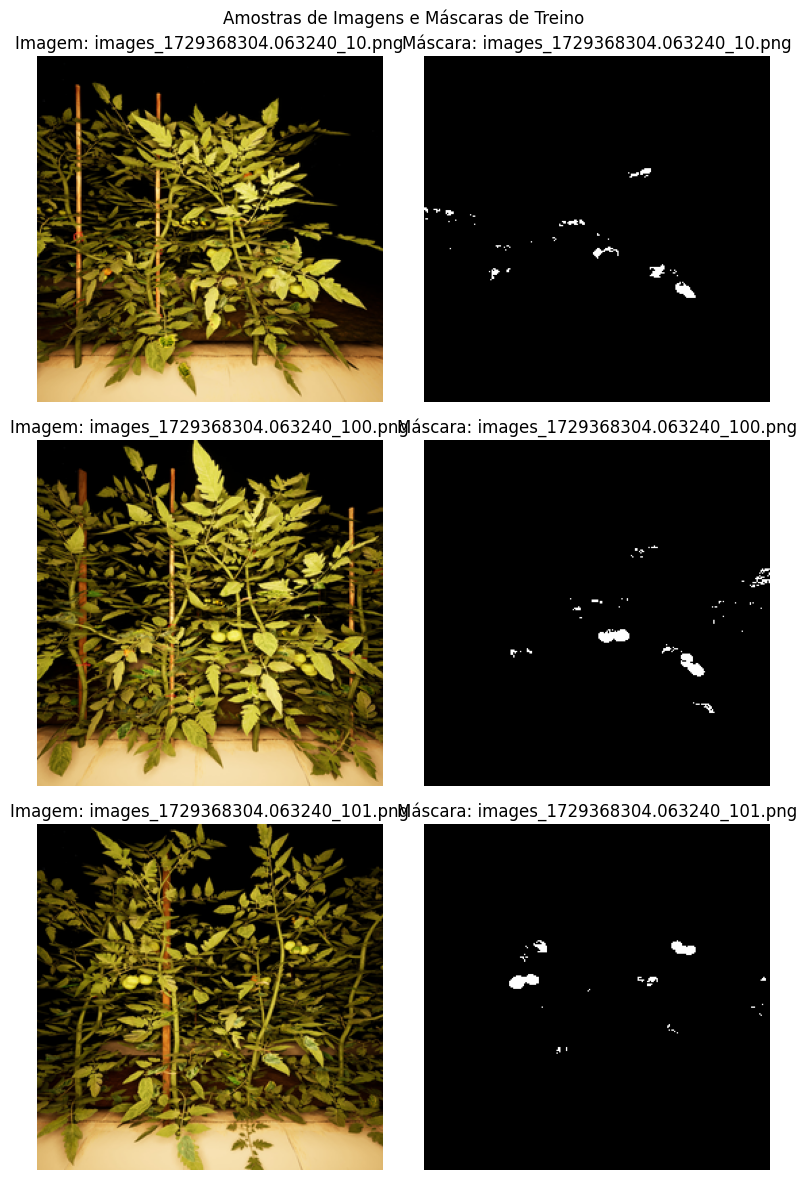

Analisando a proporção de pixels de 'tomate' nas máscaras de treino...


100%|██████████| 100/100 [00:00<00:00, 3070.50it/s]


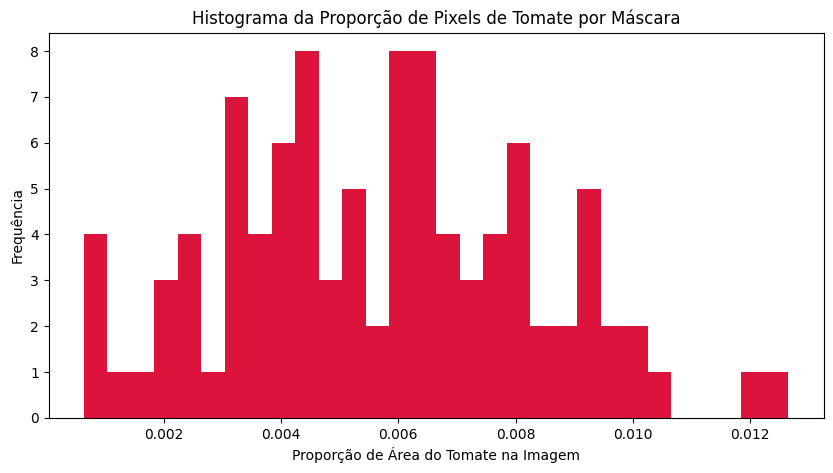

Análise concluída. Média da proporção (em imagens com tomates): 0.0057


In [4]:
# CELULA 4
# a) Pré-processamento, análise estatística dos dados, visualização

# Vamos visualizar algumas imagens e máscaras para entender os dados
train_img_dir = os.path.join(DATA_DIR, "train/images")
train_mask_dir = os.path.join(DATA_DIR, "train/masks")

# Pegar uma lista de imagens (assumindo que os nomes correspondem)
sample_images = os.listdir(train_img_dir)[:3]

fig, axs = plt.subplots(len(sample_images), 2, figsize=(8, 12))
fig.suptitle('Amostras de Imagens e Máscaras de Treino')

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_img_dir, img_name)
    # Assumindo que a máscara tem o mesmo nome, mas talvez extensão diferente
    # Tente .png ou .jpg se necessário
    mask_path = os.path.join(train_mask_dir, img_name.replace('.jpg', '.png'))
    if not os.path.exists(mask_path):
        mask_path = os.path.join(train_mask_dir, img_name)


    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L") # Converter para tons de cinza

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Imagem: {img_name}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title(f"Máscara: {os.path.basename(mask_path)}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Análise Estatística Simples: Proporção de pixels de tomate
print("Analisando a proporção de pixels de 'tomate' nas máscaras de treino...")
mask_files = os.listdir(train_mask_dir)
tomato_proportions = []
for mask_file in tqdm(mask_files[:100]): # Analisar as primeiras 100 para ser rápido
    mask_path = os.path.join(train_mask_dir, mask_file)
    mask_np = np.array(Image.open(mask_path).convert("L"))
    proportion = np.sum(mask_np > 128) / (mask_np.shape[0] * mask_np.shape[1])
    if proportion > 0: # Apenas se houver tomate
        tomato_proportions.append(proportion)

plt.figure(figsize=(10, 5))
plt.hist(tomato_proportions, bins=30, color='crimson')
plt.title('Histograma da Proporção de Pixels de Tomate por Máscara')
plt.xlabel('Proporção de Área do Tomate na Imagem')
plt.ylabel('Frequência')
plt.show()
print(f"Análise concluída. Média da proporção (em imagens com tomates): {np.mean(tomato_proportions):.4f}")

In [5]:
# CELULA 5
# Classe customizada para carregar os dados
class TomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)

        # Tratar extensões diferentes entre imagem e máscara
        mask_name = img_name
        possible_mask_exts = ['.png', '.jpg', '.jpeg']
        for ext in possible_mask_exts:
            if mask_name.endswith(ext):
                base_name = mask_name[:-len(ext)]
                break
        else:
            base_name = mask_name

        mask_path = None
        for ext in possible_mask_exts:
            potential_path = os.path.join(self.mask_dir, base_name + ext)
            if os.path.exists(potential_path):
                mask_path = potential_path
                break

        if mask_path is None:
            # Tenta com o mesmo nome exato se falhar
             mask_path = os.path.join(self.mask_dir, img_name)
             if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem {img_name}")


        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        # Normalizar máscara para 0.0-1.0
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Definir transformações (redimensionamento e conversão para tensor)
# Para data augmentation, pode-se usar a biblioteca Albumentations
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# Por simplicidade, usaremos torchvision transforms
NUM_WORKERS = 0 # <<<< COMECE COM ESTE VALOR

# --- Transformações ---
# Como você já pré-processou, não precisamos mais do Resize
# Definir as transformações básicas (sem augmentation aqui)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


class CustomTomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform, mask_transform, apply_augmentation=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.apply_augmentation = apply_augmentation # Novo parâmetro para controlar a augmentation
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        
        # Lógica para encontrar a máscara correspondente
        base_name, _ = os.path.splitext(self.images[index])
        mask_path = os.path.join(self.mask_dir, base_name + ".png")
        if not os.path.exists(mask_path):
            mask_path = os.path.join(self.mask_dir, self.images[index])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # --- NOVA LÓGICA DE AUGMENTATION ---
        if self.apply_augmentation:
            # Flip Horizontal Aleatório
            if torch.rand(1) < 0.5:
                image = F.hflip(image)
                mask = F.hflip(mask)
            
            # Flip Vertical Aleatório
            if torch.rand(1) < 0.5:
                image = F.vflip(image)
                mask = F.vflip(mask)
        
        # Aplicar transformações finais (ToTensor, Normalize)
        image = self.img_transform(image)
        mask = self.mask_transform(mask)
        
        mask = (mask > 0.5).float()
        
        return image, mask


# Criar Datasets
try:
    # ATENÇÃO: Verifique se o DATA_DIR está apontando para a pasta pré-processada (ex: .../processed_data_256)
    train_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "train/images"),
        mask_dir=os.path.join(DATA_DIR, "train/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform,
        apply_augmentation=True # << ATIVADO!
    )

    val_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "validation/images"),
        mask_dir=os.path.join(DATA_DIR, "validation/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform,
        apply_augmentation=False # << Desativado para validação
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    print(f"Dataset de treino: {len(train_ds)} amostras.")
    print(f"Dataset de validação: {len(val_ds)} amostras.")
    print(f"DataLoader usando {NUM_WORKERS} workers.")

except Exception as e:
    print(f"Ocorreu um erro ao criar os datasets: {e}")

print(f"Dataset de treino: {len(train_ds)} amostras.")
print(f"Dataset de validação: {len(val_ds)} amostras.")

Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.
DataLoader usando 0 workers.
Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.


In [6]:
# CELULA 6
# Bloco de convolução dupla usado na U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# Implementação da U-Net
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (Down path)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder (Up path)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Teste rápido para ver se a arquitetura está correta
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
x = torch.randn(2, 3, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"]).to(DEVICE)
preds = model(x)
assert preds.shape == (2, 1, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"])
print("Arquitetura U-Net carregada com sucesso!")

Arquitetura U-Net carregada com sucesso!


In [7]:
# CELULA 7
# Métrica 1: Dice Coefficient / F1 Score
# Essencial para artigos de segmentação
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs) # Aplicar sigmoid para ter probabilidades

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Métrica 2: Intersection over Union (IoU) / Jaccard Index
# Também essencial
def check_accuracy_and_get_metrics(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1) if len(y.shape) == 3 else y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            # Calcular Dice e IoU por lote e somar
            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            dice_score += (2. * intersection) / ((preds + y).sum() + 1e-8)
            iou_score += intersection / (union + 1e-8)


    accuracy = num_correct/num_pixels*100
    avg_dice = dice_score/len(loader)
    avg_iou = iou_score/len(loader)

    print(f"Acurácia de pixels: {accuracy:.2f}%")
    print(f"Dice Score (Média): {avg_dice:.4f}")
    print(f"IoU/Jaccard (Média): {avg_iou:.4f}")

    model.train()
    return avg_iou, avg_dice

# Escolher a função de perda com base na configuração
if config["LOSS_FUNCTION"] == "BCE":
    loss_fn = nn.BCEWithLogitsLoss()
elif config["LOSS_FUNCTION"] == "Dice":
    loss_fn = DiceLoss()
elif config["LOSS_FUNCTION"] == "DiceBCE":
    class DiceBCELoss(nn.Module):
        def __init__(self, weight=None, size_average=True):
            super(DiceBCELoss, self).__init__()
        def forward(self, inputs, targets, smooth=1):
            inputs_sig = torch.sigmoid(inputs)
            inputs_flat = inputs_sig.view(-1)
            targets_flat = targets.view(-1)
            intersection = (inputs_flat * targets_flat).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
            bce = nn.BCEWithLogitsLoss()(inputs, targets)
            return bce + dice_loss
    loss_fn = DiceBCELoss()

# Escolher o otimizador
if config["OPTIMIZER"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
elif config["OPTIMIZER"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=config["LEARNING_RATE"], momentum=0.9)

print(f"Otimizador: {config['OPTIMIZER']}, Função de Perda: {config['LOSS_FUNCTION']}")

Otimizador: Adam, Função de Perda: DiceBCE


In [8]:
# CELULA 8
# Função para o loop de uma época
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    total_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        # Adicionar dimensão de canal para a máscara
        targets = targets.float().to(device=DEVICE)

        # Forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm loop
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(loader)

# --- INÍCIO DO TREINAMENTO ---
history = {'train_loss': [], 'val_iou': [], 'val_dice': []}
best_val_iou = -1.0
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
scaler = torch.cuda.amp.GradScaler()

# Instancia o Agendador de Taxa de Aprendizado
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'max', # Queremos maximizar o IoU
    factor=scheduler_config["factor"],
    patience=scheduler_config["patience"],
    min_lr=scheduler_config["min_lr"],
    verbose=scheduler_config["verbose"]
)

# --- INICIALIZAÇÃO DO LOG ---
best_val_iou = -1.0

# Cria o arquivo CSV e escreve o cabeçalho
with open(CSV_LOG_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    # MUDANÇA 1: Adicionada a coluna 'duration_sec' ao cabeçalho
    writer.writerow(['epoch', 'train_loss', 'val_iou', 'val_dice', 'learning_rate', 'duration_sec'])
print(f"Arquivo de log criado em: {CSV_LOG_PATH}")

# --- LOOP DE TREINAMENTO ---
print("\n--- Iniciando o Treinamento Final ---")
for epoch in range(config["NUM_EPOCHS"]):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    model.train()
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

    model.eval()
    val_iou, val_dice = check_accuracy_and_get_metrics(val_loader, model, device=DEVICE)
    
    # Calcula a duração da época ANTES de imprimir, para poder salvar no log
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    # Imprime o resumo da época
    print(f"\n--- ÉPOCA {epoch+1}/{config['NUM_EPOCHS']} ---")
    print(f"Loss de Treino: {train_loss:.4f} | LR: {current_lr:.2e}")
    print(f"Validação -> IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")
    print(f"Duração da Época: {epoch_duration:.2f} segundos")

    scheduler.step(val_iou)

    # Salva os dados da época no arquivo CSV
    with open(CSV_LOG_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        # MUDANÇA 2: Adicionada a variável epoch_duration à linha salva
        writer.writerow([epoch+1, train_loss, val_iou.item(), val_dice.item(), current_lr, epoch_duration])

    # Salva o melhor modelo
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"** Novo melhor IoU: {best_val_iou:.4f}. Modelo salvo! **")

print("--- Treinamento Concluído ---")


Arquivo de log criado em: ./training_log.csv

--- Iniciando o Treinamento Final ---


100%|██████████| 4285/4285 [08:26<00:00,  8.46it/s, loss=0.53] 


Acurácia de pixels: 99.68%
Dice Score (Média): 0.6830
IoU/Jaccard (Média): 0.5343

--- ÉPOCA 1/100 ---
Loss de Treino: 0.5947 | LR: 1.00e-04
Validação -> IoU: 0.5343 | Dice: 0.6830
Duração da Época: 560.10 segundos
** Novo melhor IoU: 0.5343. Modelo salvo! **


100%|██████████| 4285/4285 [07:46<00:00,  9.18it/s, loss=0.261]


Acurácia de pixels: 99.73%
Dice Score (Média): 0.7497
IoU/Jaccard (Média): 0.6125

--- ÉPOCA 2/100 ---
Loss de Treino: 0.2991 | LR: 1.00e-04
Validação -> IoU: 0.6125 | Dice: 0.7497
Duração da Época: 517.63 segundos
** Novo melhor IoU: 0.6125. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.209]


Acurácia de pixels: 99.74%
Dice Score (Média): 0.7710
IoU/Jaccard (Média): 0.6367

--- ÉPOCA 3/100 ---
Loss de Treino: 0.2648 | LR: 1.00e-04
Validação -> IoU: 0.6367 | Dice: 0.7710
Duração da Época: 515.13 segundos
** Novo melhor IoU: 0.6367. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.364] 


Acurácia de pixels: 99.76%
Dice Score (Média): 0.7872
IoU/Jaccard (Média): 0.6573

--- ÉPOCA 4/100 ---
Loss de Treino: 0.2451 | LR: 1.00e-04
Validação -> IoU: 0.6573 | Dice: 0.7872
Duração da Época: 515.52 segundos
** Novo melhor IoU: 0.6573. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.27]  


Acurácia de pixels: 99.76%
Dice Score (Média): 0.7889
IoU/Jaccard (Média): 0.6597

--- ÉPOCA 5/100 ---
Loss de Treino: 0.2322 | LR: 1.00e-04
Validação -> IoU: 0.6597 | Dice: 0.7889
Duração da Época: 515.70 segundos
** Novo melhor IoU: 0.6597. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.319] 


Acurácia de pixels: 99.78%
Dice Score (Média): 0.8018
IoU/Jaccard (Média): 0.6761

--- ÉPOCA 6/100 ---
Loss de Treino: 0.2220 | LR: 1.00e-04
Validação -> IoU: 0.6761 | Dice: 0.8018
Duração da Época: 515.27 segundos
** Novo melhor IoU: 0.6761. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.147] 


Acurácia de pixels: 99.78%
Dice Score (Média): 0.8072
IoU/Jaccard (Média): 0.6836

--- ÉPOCA 7/100 ---
Loss de Treino: 0.2135 | LR: 1.00e-04
Validação -> IoU: 0.6836 | Dice: 0.8072
Duração da Época: 515.38 segundos
** Novo melhor IoU: 0.6836. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.118] 


Acurácia de pixels: 99.79%
Dice Score (Média): 0.8112
IoU/Jaccard (Média): 0.6895

--- ÉPOCA 8/100 ---
Loss de Treino: 0.2068 | LR: 1.00e-04
Validação -> IoU: 0.6895 | Dice: 0.8112
Duração da Época: 516.02 segundos
** Novo melhor IoU: 0.6895. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.196] 


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8206
IoU/Jaccard (Média): 0.7014

--- ÉPOCA 9/100 ---
Loss de Treino: 0.2000 | LR: 1.00e-04
Validação -> IoU: 0.7014 | Dice: 0.8206
Duração da Época: 515.90 segundos
** Novo melhor IoU: 0.7014. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.131] 


Acurácia de pixels: 99.79%
Dice Score (Média): 0.8222
IoU/Jaccard (Média): 0.7032

--- ÉPOCA 10/100 ---
Loss de Treino: 0.1950 | LR: 1.00e-04
Validação -> IoU: 0.7032 | Dice: 0.8222
Duração da Época: 515.44 segundos
** Novo melhor IoU: 0.7032. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.158] 


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8293
IoU/Jaccard (Média): 0.7131

--- ÉPOCA 11/100 ---
Loss de Treino: 0.1906 | LR: 1.00e-04
Validação -> IoU: 0.7131 | Dice: 0.8293
Duração da Época: 515.30 segundos
** Novo melhor IoU: 0.7131. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.07]  


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8307
IoU/Jaccard (Média): 0.7150

--- ÉPOCA 12/100 ---
Loss de Treino: 0.1861 | LR: 1.00e-04
Validação -> IoU: 0.7150 | Dice: 0.8307
Duração da Época: 515.48 segundos
** Novo melhor IoU: 0.7150. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.241] 


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8296
IoU/Jaccard (Média): 0.7138

--- ÉPOCA 13/100 ---
Loss de Treino: 0.1826 | LR: 1.00e-04
Validação -> IoU: 0.7138 | Dice: 0.8296
Duração da Época: 515.30 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.253] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8377
IoU/Jaccard (Média): 0.7246

--- ÉPOCA 14/100 ---
Loss de Treino: 0.1802 | LR: 1.00e-04
Validação -> IoU: 0.7246 | Dice: 0.8377
Duração da Época: 515.28 segundos
** Novo melhor IoU: 0.7246. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.146] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8382
IoU/Jaccard (Média): 0.7254

--- ÉPOCA 15/100 ---
Loss de Treino: 0.1772 | LR: 1.00e-04
Validação -> IoU: 0.7254 | Dice: 0.8382
Duração da Época: 515.83 segundos
** Novo melhor IoU: 0.7254. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.309] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8400
IoU/Jaccard (Média): 0.7280

--- ÉPOCA 16/100 ---
Loss de Treino: 0.1750 | LR: 1.00e-04
Validação -> IoU: 0.7280 | Dice: 0.8400
Duração da Época: 516.00 segundos
** Novo melhor IoU: 0.7280. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.128] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8428
IoU/Jaccard (Média): 0.7320

--- ÉPOCA 17/100 ---
Loss de Treino: 0.1725 | LR: 1.00e-04
Validação -> IoU: 0.7320 | Dice: 0.8428
Duração da Época: 515.62 segundos
** Novo melhor IoU: 0.7320. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.203] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8447
IoU/Jaccard (Média): 0.7347

--- ÉPOCA 18/100 ---
Loss de Treino: 0.1698 | LR: 1.00e-04
Validação -> IoU: 0.7347 | Dice: 0.8447
Duração da Época: 515.39 segundos
** Novo melhor IoU: 0.7347. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.126] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8456
IoU/Jaccard (Média): 0.7359

--- ÉPOCA 19/100 ---
Loss de Treino: 0.1686 | LR: 1.00e-04
Validação -> IoU: 0.7359 | Dice: 0.8456
Duração da Época: 515.29 segundos
** Novo melhor IoU: 0.7359. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.125] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8475
IoU/Jaccard (Média): 0.7385

--- ÉPOCA 20/100 ---
Loss de Treino: 0.1667 | LR: 1.00e-04
Validação -> IoU: 0.7385 | Dice: 0.8475
Duração da Época: 515.26 segundos
** Novo melhor IoU: 0.7385. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.15]  


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8464
IoU/Jaccard (Média): 0.7373

--- ÉPOCA 21/100 ---
Loss de Treino: 0.1649 | LR: 1.00e-04
Validação -> IoU: 0.7373 | Dice: 0.8464
Duração da Época: 515.39 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.254] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8494
IoU/Jaccard (Média): 0.7416

--- ÉPOCA 22/100 ---
Loss de Treino: 0.1635 | LR: 1.00e-04
Validação -> IoU: 0.7416 | Dice: 0.8494
Duração da Época: 515.49 segundos
** Novo melhor IoU: 0.7416. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.287] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8531
IoU/Jaccard (Média): 0.7466

--- ÉPOCA 23/100 ---
Loss de Treino: 0.1624 | LR: 1.00e-04
Validação -> IoU: 0.7466 | Dice: 0.8531
Duração da Época: 515.84 segundos
** Novo melhor IoU: 0.7466. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.221] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8531
IoU/Jaccard (Média): 0.7467

--- ÉPOCA 24/100 ---
Loss de Treino: 0.1609 | LR: 1.00e-04
Validação -> IoU: 0.7467 | Dice: 0.8531
Duração da Época: 515.80 segundos
** Novo melhor IoU: 0.7467. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.253] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8541
IoU/Jaccard (Média): 0.7481

--- ÉPOCA 25/100 ---
Loss de Treino: 0.1596 | LR: 1.00e-04
Validação -> IoU: 0.7481 | Dice: 0.8541
Duração da Época: 515.55 segundos
** Novo melhor IoU: 0.7481. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.0813]


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8536
IoU/Jaccard (Média): 0.7475

--- ÉPOCA 26/100 ---
Loss de Treino: 0.1579 | LR: 1.00e-04
Validação -> IoU: 0.7475 | Dice: 0.8536
Duração da Época: 515.38 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.16]  


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8538
IoU/Jaccard (Média): 0.7478

--- ÉPOCA 27/100 ---
Loss de Treino: 0.1571 | LR: 1.00e-04
Validação -> IoU: 0.7478 | Dice: 0.8538
Duração da Época: 515.43 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.182] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8555
IoU/Jaccard (Média): 0.7502

--- ÉPOCA 28/100 ---
Loss de Treino: 0.1562 | LR: 1.00e-04
Validação -> IoU: 0.7502 | Dice: 0.8555
Duração da Época: 515.47 segundos
** Novo melhor IoU: 0.7502. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.248] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8573
IoU/Jaccard (Média): 0.7529

--- ÉPOCA 29/100 ---
Loss de Treino: 0.1548 | LR: 1.00e-04
Validação -> IoU: 0.7529 | Dice: 0.8573
Duração da Época: 515.50 segundos
** Novo melhor IoU: 0.7529. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.172] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8573
IoU/Jaccard (Média): 0.7528

--- ÉPOCA 30/100 ---
Loss de Treino: 0.1542 | LR: 1.00e-04
Validação -> IoU: 0.7528 | Dice: 0.8573
Duração da Época: 515.83 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.233] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8587
IoU/Jaccard (Média): 0.7548

--- ÉPOCA 31/100 ---
Loss de Treino: 0.1537 | LR: 1.00e-04
Validação -> IoU: 0.7548 | Dice: 0.8587
Duração da Época: 516.00 segundos
** Novo melhor IoU: 0.7548. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.167] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8592
IoU/Jaccard (Média): 0.7555

--- ÉPOCA 32/100 ---
Loss de Treino: 0.1526 | LR: 1.00e-04
Validação -> IoU: 0.7555 | Dice: 0.8592
Duração da Época: 515.94 segundos
** Novo melhor IoU: 0.7555. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.152] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8594
IoU/Jaccard (Média): 0.7560

--- ÉPOCA 33/100 ---
Loss de Treino: 0.1517 | LR: 1.00e-04
Validação -> IoU: 0.7560 | Dice: 0.8594
Duração da Época: 515.73 segundos
** Novo melhor IoU: 0.7560. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.169] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8593
IoU/Jaccard (Média): 0.7557

--- ÉPOCA 34/100 ---
Loss de Treino: 0.1507 | LR: 1.00e-04
Validação -> IoU: 0.7557 | Dice: 0.8593
Duração da Época: 515.53 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.0708]


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8609
IoU/Jaccard (Média): 0.7580

--- ÉPOCA 35/100 ---
Loss de Treino: 0.1497 | LR: 1.00e-04
Validação -> IoU: 0.7580 | Dice: 0.8609
Duração da Época: 515.37 segundos
** Novo melhor IoU: 0.7580. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.168] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8613
IoU/Jaccard (Média): 0.7588

--- ÉPOCA 36/100 ---
Loss de Treino: 0.1491 | LR: 1.00e-04
Validação -> IoU: 0.7588 | Dice: 0.8613
Duração da Época: 515.29 segundos
** Novo melhor IoU: 0.7588. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.187] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8617
IoU/Jaccard (Média): 0.7593

--- ÉPOCA 37/100 ---
Loss de Treino: 0.1484 | LR: 1.00e-04
Validação -> IoU: 0.7593 | Dice: 0.8617
Duração da Época: 515.70 segundos
** Novo melhor IoU: 0.7593. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.152] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8630
IoU/Jaccard (Média): 0.7613

--- ÉPOCA 38/100 ---
Loss de Treino: 0.1472 | LR: 1.00e-04
Validação -> IoU: 0.7613 | Dice: 0.8630
Duração da Época: 515.94 segundos
** Novo melhor IoU: 0.7613. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.183] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8624
IoU/Jaccard (Média): 0.7603

--- ÉPOCA 39/100 ---
Loss de Treino: 0.1469 | LR: 1.00e-04
Validação -> IoU: 0.7603 | Dice: 0.8624
Duração da Época: 516.06 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.333] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8623
IoU/Jaccard (Média): 0.7601

--- ÉPOCA 40/100 ---
Loss de Treino: 0.1459 | LR: 1.00e-04
Validação -> IoU: 0.7601 | Dice: 0.8623
Duração da Época: 515.68 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.203] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8644
IoU/Jaccard (Média): 0.7634

--- ÉPOCA 41/100 ---
Loss de Treino: 0.1454 | LR: 1.00e-04
Validação -> IoU: 0.7634 | Dice: 0.8644
Duração da Época: 515.44 segundos
** Novo melhor IoU: 0.7634. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.106] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8646
IoU/Jaccard (Média): 0.7637

--- ÉPOCA 42/100 ---
Loss de Treino: 0.1450 | LR: 1.00e-04
Validação -> IoU: 0.7637 | Dice: 0.8646
Duração da Época: 515.47 segundos
** Novo melhor IoU: 0.7637. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.248] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8647
IoU/Jaccard (Média): 0.7638

--- ÉPOCA 43/100 ---
Loss de Treino: 0.1439 | LR: 1.00e-04
Validação -> IoU: 0.7638 | Dice: 0.8647
Duração da Época: 515.57 segundos
** Novo melhor IoU: 0.7638. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.24]  


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8658
IoU/Jaccard (Média): 0.7655

--- ÉPOCA 44/100 ---
Loss de Treino: 0.1433 | LR: 1.00e-04
Validação -> IoU: 0.7655 | Dice: 0.8658
Duração da Época: 515.38 segundos
** Novo melhor IoU: 0.7655. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.0665]


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8658
IoU/Jaccard (Média): 0.7654

--- ÉPOCA 45/100 ---
Loss de Treino: 0.1427 | LR: 1.00e-04
Validação -> IoU: 0.7654 | Dice: 0.8658
Duração da Época: 515.66 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.1]   


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8656
IoU/Jaccard (Média): 0.7651

--- ÉPOCA 46/100 ---
Loss de Treino: 0.1422 | LR: 1.00e-04
Validação -> IoU: 0.7651 | Dice: 0.8656
Duração da Época: 516.04 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.20it/s, loss=0.153] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8668
IoU/Jaccard (Média): 0.7670

--- ÉPOCA 47/100 ---
Loss de Treino: 0.1416 | LR: 1.00e-04
Validação -> IoU: 0.7670 | Dice: 0.8668
Duração da Época: 516.49 segundos
** Novo melhor IoU: 0.7670. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.154] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8660
IoU/Jaccard (Média): 0.7658

--- ÉPOCA 48/100 ---
Loss de Treino: 0.1413 | LR: 1.00e-04
Validação -> IoU: 0.7658 | Dice: 0.8660
Duração da Época: 516.01 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.0834]


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8671
IoU/Jaccard (Média): 0.7674

--- ÉPOCA 49/100 ---
Loss de Treino: 0.1408 | LR: 1.00e-04
Validação -> IoU: 0.7674 | Dice: 0.8671
Duração da Época: 515.78 segundos
** Novo melhor IoU: 0.7674. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.139] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8673
IoU/Jaccard (Média): 0.7678

--- ÉPOCA 50/100 ---
Loss de Treino: 0.1402 | LR: 1.00e-04
Validação -> IoU: 0.7678 | Dice: 0.8673
Duração da Época: 515.69 segundos
** Novo melhor IoU: 0.7678. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.20it/s, loss=0.207] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8672
IoU/Jaccard (Média): 0.7676

--- ÉPOCA 51/100 ---
Loss de Treino: 0.1398 | LR: 1.00e-04
Validação -> IoU: 0.7676 | Dice: 0.8672
Duração da Época: 516.29 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.144] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8689
IoU/Jaccard (Média): 0.7702

--- ÉPOCA 52/100 ---
Loss de Treino: 0.1394 | LR: 1.00e-04
Validação -> IoU: 0.7702 | Dice: 0.8689
Duração da Época: 515.73 segundos
** Novo melhor IoU: 0.7702. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.20it/s, loss=0.146] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8683
IoU/Jaccard (Média): 0.7692

--- ÉPOCA 53/100 ---
Loss de Treino: 0.1391 | LR: 1.00e-04
Validação -> IoU: 0.7692 | Dice: 0.8683
Duração da Época: 516.09 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.12]  


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8694
IoU/Jaccard (Média): 0.7709

--- ÉPOCA 54/100 ---
Loss de Treino: 0.1381 | LR: 1.00e-04
Validação -> IoU: 0.7709 | Dice: 0.8694
Duração da Época: 516.02 segundos
** Novo melhor IoU: 0.7709. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.20it/s, loss=0.139] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8696
IoU/Jaccard (Média): 0.7712

--- ÉPOCA 55/100 ---
Loss de Treino: 0.1375 | LR: 1.00e-04
Validação -> IoU: 0.7712 | Dice: 0.8696
Duração da Época: 516.35 segundos
** Novo melhor IoU: 0.7712. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.169] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8699
IoU/Jaccard (Média): 0.7718

--- ÉPOCA 56/100 ---
Loss de Treino: 0.1372 | LR: 1.00e-04
Validação -> IoU: 0.7718 | Dice: 0.8699
Duração da Época: 515.86 segundos
** Novo melhor IoU: 0.7718. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.186] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8698
IoU/Jaccard (Média): 0.7716

--- ÉPOCA 57/100 ---
Loss de Treino: 0.1366 | LR: 1.00e-04
Validação -> IoU: 0.7716 | Dice: 0.8698
Duração da Época: 515.58 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.192] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8705
IoU/Jaccard (Média): 0.7727

--- ÉPOCA 58/100 ---
Loss de Treino: 0.1362 | LR: 1.00e-04
Validação -> IoU: 0.7727 | Dice: 0.8705
Duração da Época: 515.80 segundos
** Novo melhor IoU: 0.7727. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.159] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8705
IoU/Jaccard (Média): 0.7725

--- ÉPOCA 59/100 ---
Loss de Treino: 0.1358 | LR: 1.00e-04
Validação -> IoU: 0.7725 | Dice: 0.8705
Duração da Época: 515.55 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.194] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8708
IoU/Jaccard (Média): 0.7731

--- ÉPOCA 60/100 ---
Loss de Treino: 0.1352 | LR: 1.00e-04
Validação -> IoU: 0.7731 | Dice: 0.8708
Duração da Época: 515.88 segundos
** Novo melhor IoU: 0.7731. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.12]  


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8715
IoU/Jaccard (Média): 0.7742

--- ÉPOCA 61/100 ---
Loss de Treino: 0.1349 | LR: 1.00e-04
Validação -> IoU: 0.7742 | Dice: 0.8715
Duração da Época: 515.93 segundos
** Novo melhor IoU: 0.7742. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.20it/s, loss=0.103] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8712
IoU/Jaccard (Média): 0.7736

--- ÉPOCA 62/100 ---
Loss de Treino: 0.1346 | LR: 1.00e-04
Validação -> IoU: 0.7736 | Dice: 0.8712
Duração da Época: 516.63 segundos


100%|██████████| 4285/4285 [07:48<00:00,  9.15it/s, loss=0.179] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8714
IoU/Jaccard (Média): 0.7741

--- ÉPOCA 63/100 ---
Loss de Treino: 0.1341 | LR: 1.00e-04
Validação -> IoU: 0.7741 | Dice: 0.8714
Duração da Época: 518.82 segundos


100%|██████████| 4285/4285 [07:48<00:00,  9.15it/s, loss=0.147] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8718
IoU/Jaccard (Média): 0.7746

--- ÉPOCA 64/100 ---
Loss de Treino: 0.1336 | LR: 1.00e-04
Validação -> IoU: 0.7746 | Dice: 0.8718
Duração da Época: 518.87 segundos
** Novo melhor IoU: 0.7746. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.183] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8723
IoU/Jaccard (Média): 0.7754

--- ÉPOCA 65/100 ---
Loss de Treino: 0.1333 | LR: 1.00e-04
Validação -> IoU: 0.7754 | Dice: 0.8723
Duração da Época: 515.25 segundos
** Novo melhor IoU: 0.7754. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.132] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8720
IoU/Jaccard (Média): 0.7749

--- ÉPOCA 66/100 ---
Loss de Treino: 0.1327 | LR: 1.00e-04
Validação -> IoU: 0.7749 | Dice: 0.8720
Duração da Época: 515.08 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.218] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8727
IoU/Jaccard (Média): 0.7760

--- ÉPOCA 67/100 ---
Loss de Treino: 0.1325 | LR: 1.00e-04
Validação -> IoU: 0.7760 | Dice: 0.8727
Duração da Época: 515.93 segundos
** Novo melhor IoU: 0.7760. Modelo salvo! **


100%|██████████| 4285/4285 [07:46<00:00,  9.19it/s, loss=0.112] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8730
IoU/Jaccard (Média): 0.7765

--- ÉPOCA 68/100 ---
Loss de Treino: 0.1319 | LR: 1.00e-04
Validação -> IoU: 0.7765 | Dice: 0.8730
Duração da Época: 516.97 segundos
** Novo melhor IoU: 0.7765. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.159] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8738
IoU/Jaccard (Média): 0.7777

--- ÉPOCA 69/100 ---
Loss de Treino: 0.1317 | LR: 1.00e-04
Validação -> IoU: 0.7777 | Dice: 0.8738
Duração da Época: 515.95 segundos
** Novo melhor IoU: 0.7777. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.168] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8735
IoU/Jaccard (Média): 0.7772

--- ÉPOCA 70/100 ---
Loss de Treino: 0.1313 | LR: 1.00e-04
Validação -> IoU: 0.7772 | Dice: 0.8735
Duração da Época: 515.46 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.23it/s, loss=0.0604]


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8737
IoU/Jaccard (Média): 0.7775

--- ÉPOCA 71/100 ---
Loss de Treino: 0.1307 | LR: 1.00e-04
Validação -> IoU: 0.7775 | Dice: 0.8737
Duração da Época: 514.66 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.157] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8734
IoU/Jaccard (Média): 0.7771

--- ÉPOCA 72/100 ---
Loss de Treino: 0.1306 | LR: 1.00e-04
Validação -> IoU: 0.7771 | Dice: 0.8734
Duração da Época: 515.05 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.111] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8736
IoU/Jaccard (Média): 0.7774

--- ÉPOCA 73/100 ---
Loss de Treino: 0.1302 | LR: 1.00e-04
Validação -> IoU: 0.7774 | Dice: 0.8736
Duração da Época: 515.53 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.0872]


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8734
IoU/Jaccard (Média): 0.7772

--- ÉPOCA 74/100 ---
Loss de Treino: 0.1297 | LR: 1.00e-04
Validação -> IoU: 0.7772 | Dice: 0.8734
Duração da Época: 515.59 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.155] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8743
IoU/Jaccard (Média): 0.7785

--- ÉPOCA 75/100 ---
Loss de Treino: 0.1291 | LR: 1.00e-04
Validação -> IoU: 0.7785 | Dice: 0.8743
Duração da Época: 515.47 segundos
** Novo melhor IoU: 0.7785. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.0639]


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8745
IoU/Jaccard (Média): 0.7788

--- ÉPOCA 76/100 ---
Loss de Treino: 0.1287 | LR: 1.00e-04
Validação -> IoU: 0.7788 | Dice: 0.8745
Duração da Época: 515.72 segundos
** Novo melhor IoU: 0.7788. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.119] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8752
IoU/Jaccard (Média): 0.7799

--- ÉPOCA 77/100 ---
Loss de Treino: 0.1285 | LR: 1.00e-04
Validação -> IoU: 0.7799 | Dice: 0.8752
Duração da Época: 515.66 segundos
** Novo melhor IoU: 0.7799. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.102] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8752
IoU/Jaccard (Média): 0.7798

--- ÉPOCA 78/100 ---
Loss de Treino: 0.1280 | LR: 1.00e-04
Validação -> IoU: 0.7798 | Dice: 0.8752
Duração da Época: 515.35 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.0977]


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8752
IoU/Jaccard (Média): 0.7799

--- ÉPOCA 79/100 ---
Loss de Treino: 0.1275 | LR: 1.00e-04
Validação -> IoU: 0.7799 | Dice: 0.8752
Duração da Época: 515.55 segundos
** Novo melhor IoU: 0.7799. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.0993]


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8756
IoU/Jaccard (Média): 0.7805

--- ÉPOCA 80/100 ---
Loss de Treino: 0.1276 | LR: 1.00e-04
Validação -> IoU: 0.7805 | Dice: 0.8756
Duração da Época: 515.26 segundos
** Novo melhor IoU: 0.7805. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.145] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8759
IoU/Jaccard (Média): 0.7810

--- ÉPOCA 81/100 ---
Loss de Treino: 0.1268 | LR: 1.00e-04
Validação -> IoU: 0.7810 | Dice: 0.8759
Duração da Época: 515.79 segundos
** Novo melhor IoU: 0.7810. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.20it/s, loss=0.144] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8757
IoU/Jaccard (Média): 0.7807

--- ÉPOCA 82/100 ---
Loss de Treino: 0.1271 | LR: 1.00e-04
Validação -> IoU: 0.7807 | Dice: 0.8757
Duração da Época: 516.05 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.163] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8766
IoU/Jaccard (Média): 0.7820

--- ÉPOCA 83/100 ---
Loss de Treino: 0.1265 | LR: 1.00e-04
Validação -> IoU: 0.7820 | Dice: 0.8766
Duração da Época: 515.82 segundos
** Novo melhor IoU: 0.7820. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.12it/s, loss=0.132] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8769
IoU/Jaccard (Média): 0.7825

--- ÉPOCA 84/100 ---
Loss de Treino: 0.1264 | LR: 1.00e-04
Validação -> IoU: 0.7825 | Dice: 0.8769
Duração da Época: 520.92 segundos
** Novo melhor IoU: 0.7825. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.131] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8765
IoU/Jaccard (Média): 0.7819

--- ÉPOCA 85/100 ---
Loss de Treino: 0.1256 | LR: 1.00e-04
Validação -> IoU: 0.7819 | Dice: 0.8765
Duração da Época: 515.55 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.202] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8766
IoU/Jaccard (Média): 0.7820

--- ÉPOCA 86/100 ---
Loss de Treino: 0.1254 | LR: 1.00e-04
Validação -> IoU: 0.7820 | Dice: 0.8766
Duração da Época: 515.51 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.192] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8774
IoU/Jaccard (Média): 0.7834

--- ÉPOCA 87/100 ---
Loss de Treino: 0.1251 | LR: 1.00e-04
Validação -> IoU: 0.7834 | Dice: 0.8774
Duração da Época: 515.16 segundos
** Novo melhor IoU: 0.7834. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.175] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8772
IoU/Jaccard (Média): 0.7830

--- ÉPOCA 88/100 ---
Loss de Treino: 0.1248 | LR: 1.00e-04
Validação -> IoU: 0.7830 | Dice: 0.8772
Duração da Época: 515.42 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.101] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8776
IoU/Jaccard (Média): 0.7837

--- ÉPOCA 89/100 ---
Loss de Treino: 0.1245 | LR: 1.00e-04
Validação -> IoU: 0.7837 | Dice: 0.8776
Duração da Época: 515.40 segundos
** Novo melhor IoU: 0.7837. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.248] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8774
IoU/Jaccard (Média): 0.7832

--- ÉPOCA 90/100 ---
Loss de Treino: 0.1239 | LR: 1.00e-04
Validação -> IoU: 0.7832 | Dice: 0.8774
Duração da Época: 515.46 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.193] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8780
IoU/Jaccard (Média): 0.7843

--- ÉPOCA 91/100 ---
Loss de Treino: 0.1241 | LR: 1.00e-04
Validação -> IoU: 0.7843 | Dice: 0.8780
Duração da Época: 515.71 segundos
** Novo melhor IoU: 0.7843. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.20it/s, loss=0.073] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8774
IoU/Jaccard (Média): 0.7832

--- ÉPOCA 92/100 ---
Loss de Treino: 0.1236 | LR: 1.00e-04
Validação -> IoU: 0.7832 | Dice: 0.8774
Duração da Época: 516.48 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.23it/s, loss=0.0685]


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8783
IoU/Jaccard (Média): 0.7847

--- ÉPOCA 93/100 ---
Loss de Treino: 0.1234 | LR: 1.00e-04
Validação -> IoU: 0.7847 | Dice: 0.8783
Duração da Época: 515.08 segundos
** Novo melhor IoU: 0.7847. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.118] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8786
IoU/Jaccard (Média): 0.7853

--- ÉPOCA 94/100 ---
Loss de Treino: 0.1227 | LR: 1.00e-04
Validação -> IoU: 0.7853 | Dice: 0.8786
Duração da Época: 515.16 segundos
** Novo melhor IoU: 0.7853. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.109] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8786
IoU/Jaccard (Média): 0.7852

--- ÉPOCA 95/100 ---
Loss de Treino: 0.1226 | LR: 1.00e-04
Validação -> IoU: 0.7852 | Dice: 0.8786
Duração da Época: 515.45 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.0825]


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8785
IoU/Jaccard (Média): 0.7850

--- ÉPOCA 96/100 ---
Loss de Treino: 0.1220 | LR: 1.00e-04
Validação -> IoU: 0.7850 | Dice: 0.8785
Duração da Época: 515.62 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.122] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8788
IoU/Jaccard (Média): 0.7855

--- ÉPOCA 97/100 ---
Loss de Treino: 0.1220 | LR: 1.00e-04
Validação -> IoU: 0.7855 | Dice: 0.8788
Duração da Época: 515.70 segundos
** Novo melhor IoU: 0.7855. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.108] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8794
IoU/Jaccard (Média): 0.7865

--- ÉPOCA 98/100 ---
Loss de Treino: 0.1220 | LR: 1.00e-04
Validação -> IoU: 0.7865 | Dice: 0.8794
Duração da Época: 515.90 segundos
** Novo melhor IoU: 0.7865. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.109] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8787
IoU/Jaccard (Média): 0.7853

--- ÉPOCA 99/100 ---
Loss de Treino: 0.1212 | LR: 1.00e-04
Validação -> IoU: 0.7853 | Dice: 0.8787
Duração da Época: 515.77 segundos


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.192] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8788
IoU/Jaccard (Média): 0.7855

--- ÉPOCA 100/100 ---
Loss de Treino: 0.1209 | LR: 1.00e-04
Validação -> IoU: 0.7855 | Dice: 0.8788
Duração da Época: 515.86 segundos
--- Treinamento Concluído ---


Carregando o melhor modelo salvo de './tomato_unet_best.pth'...
Carregando log de treinamento de './training_log.csv'...
Gerando gráficos de treinamento...


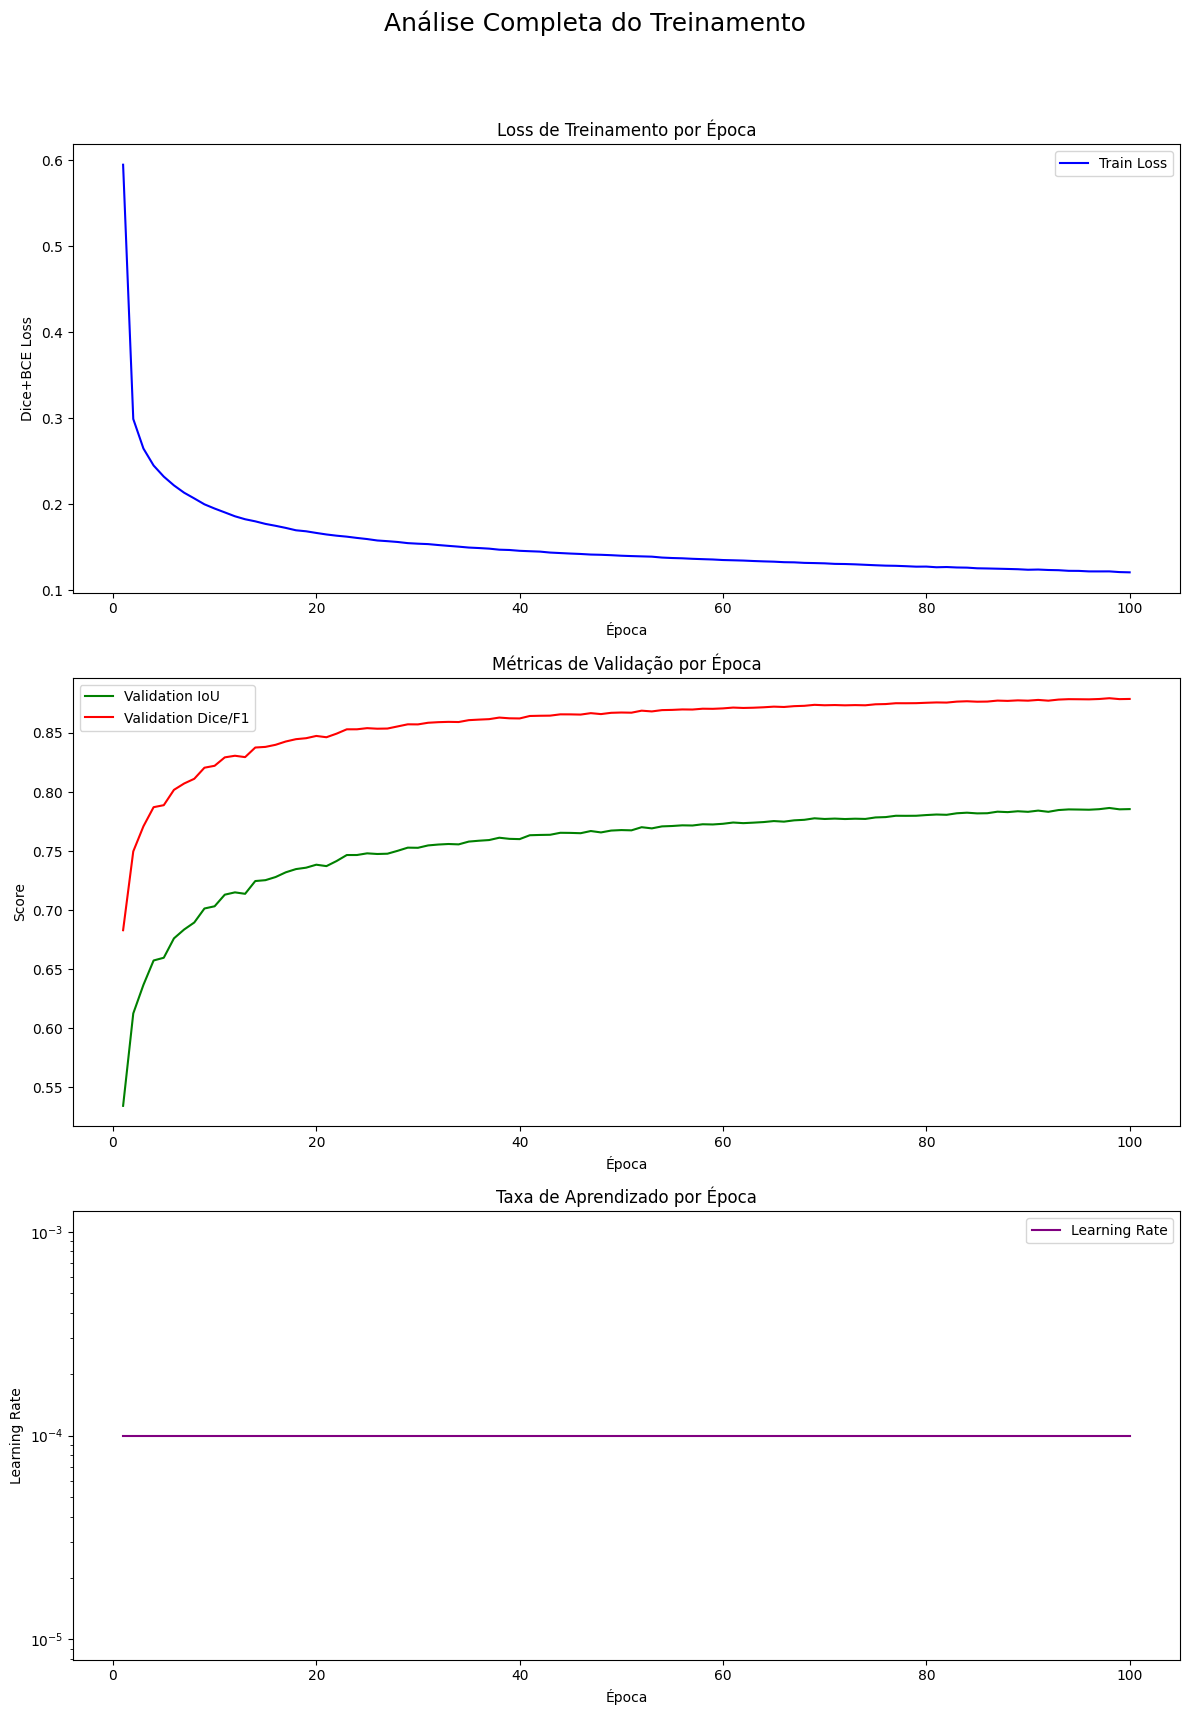


Calculando métricas finais detalhadas no conjunto de validação...


Calculando Métricas Finais: 100%|██████████| 1058/1058 [01:03<00:00, 16.64it/s]



      RESULTADOS FINAIS DO MELHOR MODELO
IoU         : 0.7865
Dice/F1     : 0.8794
Precision   : 0.9195
Recall      : 0.8435

Gerando visualizações de predições do melhor modelo...


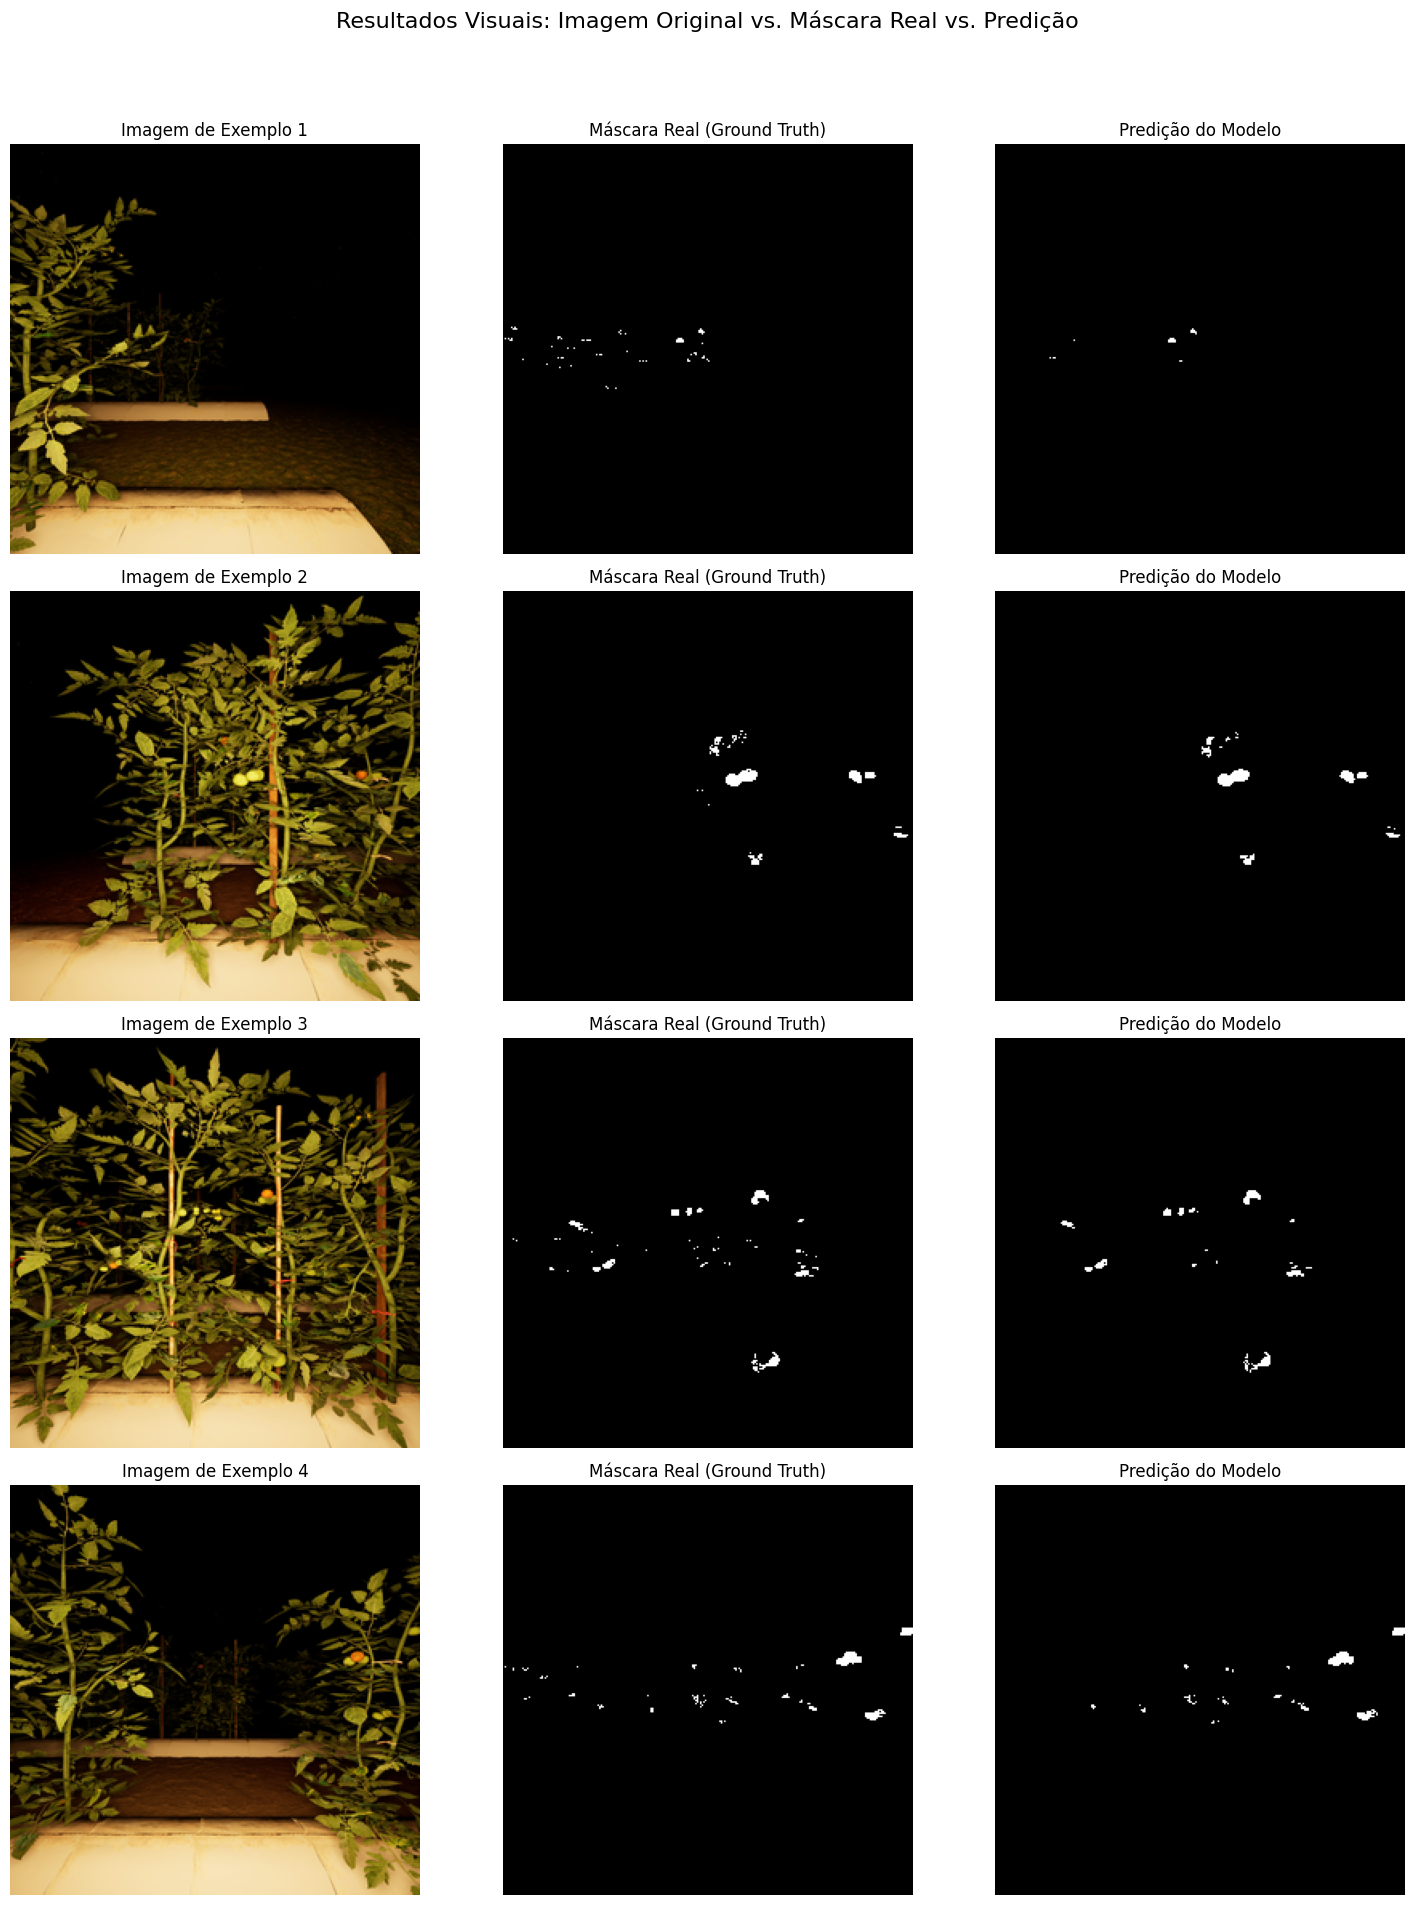

In [9]:
# ===================================================================
# CÉLULA 11: ANÁLISE FINAL, GRÁFICOS E MÉTRICAS (SUBSTITUIR)
# ===================================================================

# --- 1. CARREGAR DADOS E O MELHOR MODELO ---
print(f"Carregando o melhor modelo salvo de '{MODEL_SAVE_PATH}'...")
# Recria a arquitetura do modelo para carregar os pesos
analysis_model = UNET(in_channels=3, out_channels=1).to(DEVICE)
analysis_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
analysis_model.eval() # Coloca o modelo em modo de avaliação definitivo

print(f"Carregando log de treinamento de '{CSV_LOG_PATH}'...")
log_df = pd.read_csv(CSV_LOG_PATH)


# --- 2. GERAR GRÁFICOS DE TREINAMENTO ---
print("Gerando gráficos de treinamento...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análise Completa do Treinamento', fontsize=18)

# Gráfico 1: Loss de Treino
sns.lineplot(x='epoch', y='train_loss', data=log_df, ax=ax1, color='blue', label='Train Loss')
ax1.set_title('Loss de Treinamento por Época')
ax1.set_xlabel('Época')
ax1.set_ylabel('Dice+BCE Loss')

# Gráfico 2: Métricas de Validação
sns.lineplot(x='epoch', y='val_iou', data=log_df, ax=ax2, color='green', label='Validation IoU')
sns.lineplot(x='epoch', y='val_dice', data=log_df, ax=ax2, color='red', label='Validation Dice/F1')
ax2.set_title('Métricas de Validação por Época')
ax2.set_xlabel('Época')
ax2.set_ylabel('Score')
ax2.legend()

# Gráfico 3: Taxa de Aprendizado
sns.lineplot(x='epoch', y='learning_rate', data=log_df, ax=ax3, color='purple', label='Learning Rate')
ax3.set_title('Taxa de Aprendizado por Época')
ax3.set_xlabel('Época')
ax3.set_ylabel('Learning Rate')
ax3.set_yscale('log') # Escala logarítmica para ver melhor as quedas

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. CÁLCULO DE MÉTRICAS FINAIS DETALHADAS ---
def calculate_final_metrics(loader, model, device):
    print("\nCalculando métricas finais detalhadas no conjunto de validação...")
    dice_scores, iou_scores, precisions, recalls = [], [], [], []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculando Métricas Finais"):
            x, y = x.to(device), y.to(device)
            if len(y.shape) == 3: y = y.unsqueeze(1)
            
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            tp = (preds * y).sum()
            fp = ((1 - y) * preds).sum()
            fn = (y * (1 - preds)).sum()
            
            precision = (tp + 1e-6) / (tp + fp + 1e-6)
            recall = (tp + 1e-6) / (tp + fn + 1e-6)
            dice = (2 * tp + 1e-6) / (2 * tp + fp + fn + 1e-6)
            iou = (tp + 1e-6) / (tp + fp + fn + 1e-6)
            
            precisions.append(precision.item())
            recalls.append(recall.item())
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    final_metrics = {
        "IoU": np.mean(iou_scores),
        "Dice/F1": np.mean(dice_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls)
    }
    return final_metrics

final_metrics = calculate_final_metrics(val_loader, analysis_model, DEVICE)


# --- 4. EXIBIR TABELA DE RESULTADOS FINAIS ---
print("\n" + "="*40)
print("      RESULTADOS FINAIS DO MELHOR MODELO")
print("="*40)
for metric, value in final_metrics.items():
    print(f"{metric:<12}: {value:.4f}")
print("="*40 + "\n")


# --- 5. VISUALIZAÇÃO QUALITATIVA DAS PREDIÇÕES ---
print("Gerando visualizações de predições do melhor modelo...")
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
val_images, val_masks = next(iter(val_loader))
num_images = min(5, len(val_images))

fig, axs = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
fig.suptitle('Resultados Visuais: Imagem Original vs. Máscara Real vs. Predição', fontsize=16)

for i in range(num_images):
    image_tensor = val_images[i].to(DEVICE)
    true_mask_np = val_masks[i].squeeze().cpu().numpy()
    
    with torch.no_grad():
        pred_mask = analysis_model(image_tensor.unsqueeze(0))
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask_np = (pred_mask > 0.5).float().squeeze().cpu().numpy()

    image_display = inv_normalize(image_tensor).cpu().permute(1, 2, 0).numpy()

    axs[i, 0].imshow(np.clip(image_display, 0, 1))
    axs[i, 0].set_title(f"Imagem de Exemplo {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(true_mask_np, cmap='gray')
    axs[i, 1].set_title("Máscara Real (Ground Truth)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(pred_mask_np, cmap='gray')
    axs[i, 2].set_title("Predição do Modelo")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()